# DATA INPUT!

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd
from shapely.geometry import box,Polygon
import analysis_tool as tool

gdfs = tool.load_all_gdfs("origin_data")
# print(len(gdfs))
# 文件内容为：gdfs["文件夹名"]
# ├── 00_Boundaries/                     # 边界
# │
# ├── 01_production_farming/             # 农作物（可耕地）
# │
# ├── 02_production_aquaculture/         # 水产养殖（海岸泻湖 + 河口）
# │
# ├── 03_production_livestock/           # 畜牧养殖（草场）
# │
# ├── 04_transformation_industry/        # 食品加工厂（GOOGLE 来源）
# │
# ├── 05_transformation_energy/          # 水厂、电厂、供热等能源基础设施
# │
# ├── 06_logistics_transportation/        # 公共交通 + 港口 + 仓储 + 配送中心
# │
# ├── 07_logistics_roads/                # 可通行道路（MultiDiGraph）
# │
# ├── 08_supply_retail/                  # 超市、市场、批发商等零售终端
# │
# ├── 09_supply_public_services/         # 公共服务设施：学校、医疗、福利
# │
# ├── 10_built_environment/              # 建成区信息（居住、商业、工业）
# │
# ├── 11_consumption_facilities/         # 餐饮、酒店、住宿类消费终端
# │
# ├── 12_consumption_landuse_mix/        # 土地混合度计算所需的 landuse 数据
# │
# ├── 13_waste_treatment/                # 废弃物处理设施：垃圾厂、废水厂


✅  已加载 00_Boundaries: Whole area.shp (1 条记录)
✅  已加载 01_production_farming: farming.shp (1647 条记录)
✅  已加载 02_production_aquaculture: aquaculture.shp (211 条记录)
✅  已加载 03_production_livestock: livestock.shp (1538 条记录)
✅  已加载 04_transformation_industry: processing.shp (103 条记录)
✅  已加载 05_transformation_energy: power_data.shp (28 条记录)
✅  已加载 06_logistics_transportation: logistic_data.shp (2 条记录)
✅  已加载 07_logistics_roads: roads_highways.shp (58252 条记录)
✅  已加载 08_supply_retail: shop_food_beverage_data.shp (432 条记录)
✅  已加载 09_supply_public_services: public_services.shp (911 条记录)
✅  已加载 10_built_environment: buildings.shp (189600 条记录)
✅  已加载 11_consumption_facilities: consumption_data.shp (2889 条记录)
✅  已加载 12_consumption_landuse_mix: landuse_data.shp (2255 条记录)
✅  已加载 13_waste_treatment: impianti_smaltimento_rifiuti.shp (10 条记录)


         power                operator operator_w            ref start_date  \
0   substation                    Enel    Q651222       11031849    2001/10   
1   substation                    None       None  dg40-2-031560       None   
2   substation                    None       None           None       None   
3         None                    None       None           None       None   
4         None                    None       None           None       None   
5         None                    None       None           None       None   
6   substation                    None       None           None       None   
7   substation                    None       None           None       None   
8   substation                    None       None           None       None   
9   substation                    None       None           None       None   
10  substation                    None       None           None       None   
11  substation                    None       None   

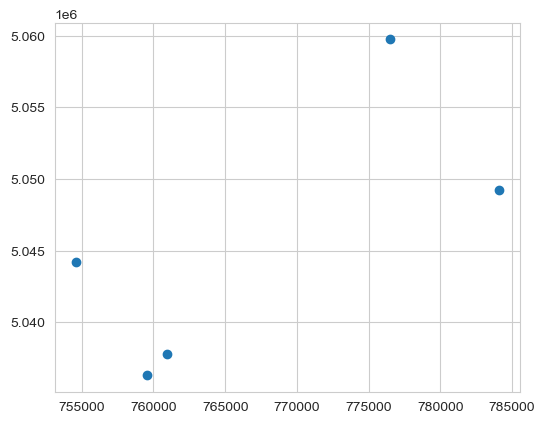

In [10]:
gdfs["05_transformation_energy"].plot()
print(gdfs["05_transformation_energy"])

# 创建网格

  addr_house       addr_stree                         name     office  \
0         22  Via Malcontenta           GLS - Venezia - V5  logistics   
1       1512             None  Trasporti Manfrin G. s.n.c.  logistics   

  addr_city addr_place addr_postc air_transp       contact_mo ground_tra  ...  \
0      None       None       None       None             None       None  ...   
1   Venezia  Dorsoduro      30123         no  +39 335 5708898         no  ...   

  descriptio cargo  port  type name_en name_vi wikidata wikipedia  \
0       None  None  None  None    None    None     None      None   
1       None  None  None  None    None    None     None      None   

                     city                        geometry  
0  Venezia, Veneto, Italy  POINT (751067.115 5037535.516)  
1  Venezia, Veneto, Italy  POINT (759747.789 5036179.024)  

[2 rows x 45 columns]


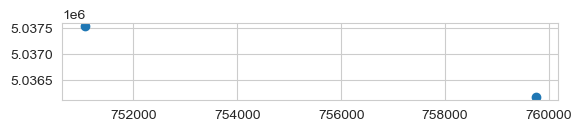

In [11]:
gdfs["06_logistics_transportation"].plot()
print(gdfs["06_logistics_transportation"])

                                   name stars      tourism      amenity  \
0                     Residence Le Dune     5  guest_house         None   
1     Ristorante Pizzeria Viale Fontana  None         None   restaurant   
2                                  None  None         None   restaurant   
3                                  None  None         None          bar   
4                              Bar Rosa  None         None          bar   
...                                 ...   ...          ...          ...   
2884                               None  None         None  marketplace   
2885               Osteria Porto Canale  None         None   restaurant   
2886            Agriturismo Cà marcello  None  guest_house         None   
2887                           Vinarium  None         None          bar   
2888          Net Riviera Sport Village  None         None   restaurant   

      cuisine wheelchair      opening_ho diet_veget check_date descriptio  \
0        None       No

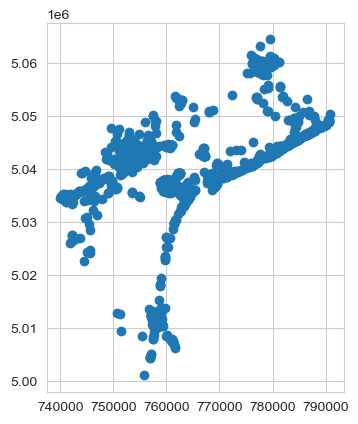

In [12]:
gdfs["11_consumption_facilities"].plot()
print(gdfs["11_consumption_facilities"])

                      name         shop  check_date         opening_ho  \
0        Metzgerei Roberto      butcher        None               None   
1         Bottega del Pane       bakery  2023-08-20               None   
2         Frutta & Verdura  greengrocer  2023-08-20               None   
3               Macelleria      butcher        None               None   
4                     None  greengrocer        None  Mo-Su 08:00-20:00   
..                     ...          ...         ...                ...   
427                   None  greengrocer        None               None   
428                   None       bakery        None               None   
429  Pasticceria Veneziana       pastry        None               None   
430      Panificio Crosara       bakery        None               None   
431                   None      butcher        None               None   

    wheelchair name_de name_it alt_name addr_house           addr_stree  ...  \
0         None    None    None 

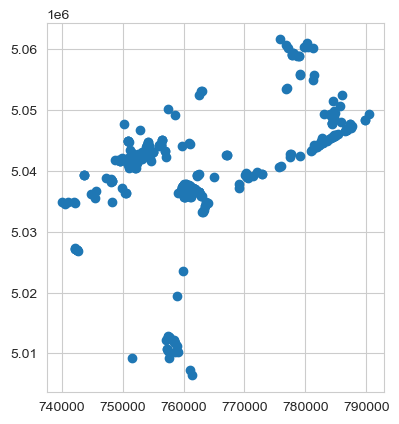

In [13]:
gdfs["08_supply_retail"].plot()
print(gdfs["08_supply_retail"])

['residential' 'industrial' 'commercial']
          landuse industrial caravan_re  name  shop  \
0     residential       None       None  None  None   
1     residential       None       None  None  None   
2     residential       None       None  None  None   
3     residential       None       None  None  None   
4     residential       None       None  None  None   
...           ...        ...        ...   ...   ...   
2250  residential       None       None  None  None   
2251  residential       None       None  None  None   
2252  residential       None       None  None  None   
2253  residential       None       None  None  None   
2254  residential       None       None  None  None   

                                   city addr_city addr_house addr_postc  \
0     Cavallino-Treporti, Veneto, Italy      None       None       None   
1     Cavallino-Treporti, Veneto, Italy      None       None       None   
2     Cavallino-Treporti, Veneto, Italy      None       None       None 

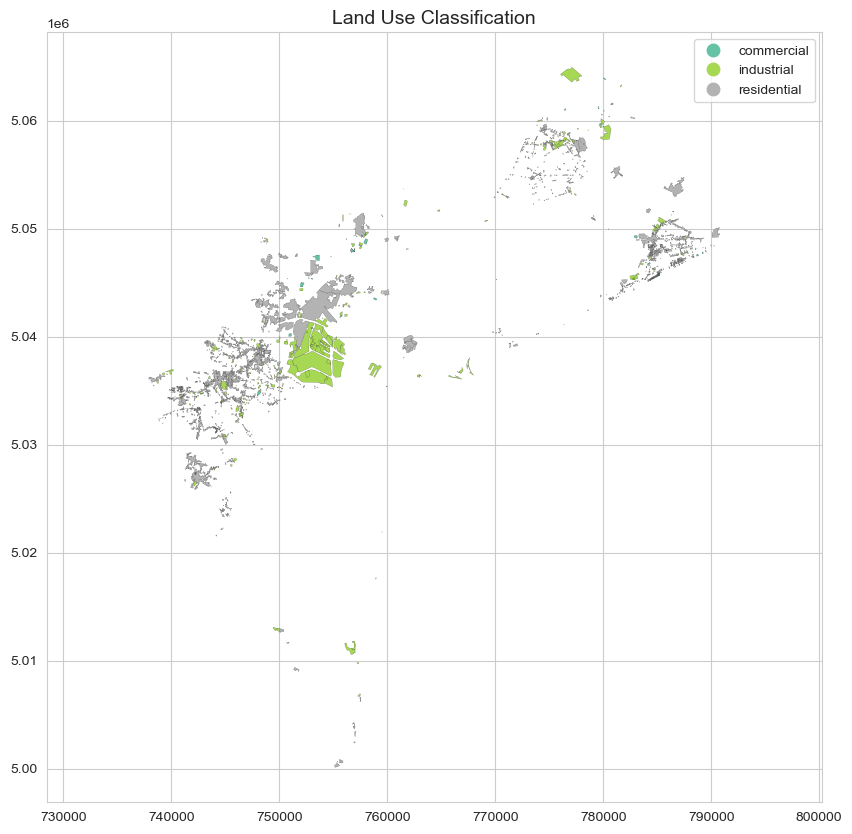

In [16]:

print(gdfs["12_consumption_landuse_mix"]["landuse"].unique())
print(gdfs["12_consumption_landuse_mix"])
fig, ax = plt.subplots(figsize=(10, 10))

# 分类着色绘图
gdfs["12_consumption_landuse_mix"].plot(column="landuse", ax=ax, legend=True, cmap="Set2", edgecolor='black', linewidth=0.1)

# 设置标题
ax.set_title("Land Use Classification", fontsize=14)

# 等比例显示
plt.axis("equal")
plt.show()

In [7]:
# # 设置格网大小（单位和你的坐标系一致，比如米）
# grid_size = 1000  # 每个正方形边长1000米（1公里）
#
# # 获取工厂数据的包络范围 (bounding box)
# minx, miny, maxx, maxy = gdfs["00_Boundaries"].total_bounds
#
# # 创建格网
# grid_cells = []
# x_left = minx
# while x_left < maxx:
#     y_bottom = miny
#     while y_bottom < maxy:
#         cell = box(x_left, y_bottom, x_left + grid_size, y_bottom + grid_size)
#         grid_cells.append(cell)
#         y_bottom += grid_size
#     x_left += grid_size
#
# # 转成GeoDataFrame
# grid = gpd.GeoDataFrame({'geometry': grid_cells})
grid= gpd.read_file(r"D:\Architecture\AAA-Master\25Spring\ISUF\UrbanFood\origin_data\grid_entropy.geojson")

## 空间连接

In [8]:
# 计算面
grid = tool.area_polygons_in_grid(gdfs["01_production_farming"], grid, "farming_area")
grid = tool.area_polygons_in_grid(gdfs["02_production_aquaculture"], grid, "farming_area")
grid = tool.area_polygons_in_grid(gdfs["03_production_livestock"], grid, "pasture_area")
grid = tool.area_polygons_in_grid(gdfs["10_built_environment"], grid, "building_area")
# 计算点
grid = tool.count_points_in_grid(gdfs["04_transformation_industry"], grid, "factory_count")
grid = tool.count_points_in_grid(gdfs["09_supply_public_services"], grid, "public_services")
grid = tool.count_points_in_grid(gdfs["13_waste_treatment"], grid, "waste_treatment")
# 计算线
grid = tool.length_lines_in_grid(gdfs["07_logistics_roads"], grid, "road_length")
# 其他


Exception ignored in: <bound method IPythonKernel._clean_thread_parent_frames of <ipykernel.ipkernel.IPythonKernel object at 0x000002963F720BB0>>
Traceback (most recent call last):
  File "D:\STUDY\anaconda3\envs\urban_morphology\lib\site-packages\ipykernel\ipkernel.py", line 775, in _clean_thread_parent_frames
    def _clean_thread_parent_frames(
KeyboardInterrupt: 


GEOSException: TopologyException: side location conflict at 777371.34947588481 5059990.5178352762 0. This can occur if the input geometry is invalid.

In [ ]:
variables = ["farming_area","farming_area","pasture_area","building_area","factory_count","public_services","waste_treatment","road_length"]

fig, axs = plt.subplots(2, 4, figsize=(18, 6))
axs = axs.flatten()
for i, var in enumerate(variables):
    grid.plot(column=var, ax=axs[i], cmap='OrRd', legend=True, edgecolor='grey', linewidth=0.2)
    axs[i].set_title(f'{var} per Grid', fontsize=12)
    axs[i].axis('off')

plt.tight_layout()
plt.show()

In [ ]:
import seaborn as sns
import pandas as pd

# 只提取需要分析的字段
df_analysis = grid[['factory_count', 'public_services','waste_treatment','road_length', 'industrial_area','agriculture_area','water_area']]
print(df_analysis)
# 计算相关性矩阵
corr_matrix = df_analysis.corr()
corr_matrix.to_csv("correlation_matrix.csv")
# 热力图可视化
plt.figure(figsize=(6, 5))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Matrix")
plt.show()

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_analysis)
kmeans = KMeans(n_clusters=6, random_state=0)
labels = kmeans.fit_predict(X_scaled)
grid['cluster'] = labels

fig, ax = plt.subplots(figsize=(10, 10))
grid.plot(column='cluster', cmap='Set1', legend=True, ax=ax, edgecolor='grey')
ax.set_title("K-Means Clustering by Urban Structure")
ax.axis('off')
plt.tight_layout()
plt.show()

cluster_means = pd.DataFrame(X_scaled, columns=df_analysis.columns)
cluster_means['cluster'] = labels
result = cluster_means.groupby('cluster').mean()
print(result)